In [1]:
MODELO = "VGG19-FineTune"

In [2]:
import os
import keras
keras.__version__
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


### Multi - GPU

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [4]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [5]:
keras.backend.tensorflow_backend.set_session(get_session())

# Directorios

In [6]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


# Modelo VGG19

In [8]:
from keras.applications.vgg19 import VGG19

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = VGG19(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Trainable Layers

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [11]:
# Después de modificar el atributo trainable
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


# Model

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 26,478,008
Trainable params: 15,892,856
Non-trainable params: 10,585,152
_________________________________________________________________


# Optimizador

In [13]:
from keras_radam import RAdam

model.compile(loss='categorical_crossentropy',
                       optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
                       metrics=['categorical_accuracy'])

# Callbacks

In [14]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

# Entrenamiento

In [15]:
history = model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=2000,
                                       validation_data=valid_generator,
                                       validation_steps=50,
                                       callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
100/100 [==============================] - 79s 793ms/step - loss: 4.9275 - categorical_accuracy: 0.0078 - val_loss: 4.7925 - val_categorical_accuracy: 0.0125
Epoch 2/2000
100/100 [==============================] - 61s 613ms/step - loss: 4.7659 - categorical_accuracy: 0.0178 - val_loss: 4.6900 - val_categorical_accuracy: 0.0208
Epoch 3/2000
100/100 [==============================] - 54s 537ms/step - loss: 4.6859 - categorical_accuracy: 0.0247 - val_loss: 4.5791 - val_categorical_accuracy: 0.0225
Epoch 4/2000
100/100 [==============================] - 60s 600ms/step - loss: 4.5851 - categorical_accuracy: 0.0231 - val_loss: 4.4296 - val_categorical_accuracy: 0.0404
Epoch 5/2000
100/100 [==============================] - 48s 480ms/step - loss: 4.6931 - categorical_accuracy: 0.0184 - val_loss: 4.7082 - val_categorical_accuracy: 0.0163
Epoch 6/2000
100/100 [==============================] - 40s 397ms/step - loss: 4.5088 - categoric

100/100 [==============================] - 39s 391ms/step - loss: 1.9590 - categorical_accuracy: 0.4509 - val_loss: 2.1457 - val_categorical_accuracy: 0.4219
Epoch 48/2000
100/100 [==============================] - 39s 393ms/step - loss: 1.9457 - categorical_accuracy: 0.4441 - val_loss: 2.1215 - val_categorical_accuracy: 0.4315
Epoch 49/2000
100/100 [==============================] - 39s 385ms/step - loss: 1.9118 - categorical_accuracy: 0.4612 - val_loss: 2.1656 - val_categorical_accuracy: 0.4050
Epoch 50/2000
100/100 [==============================] - 40s 395ms/step - loss: 1.9654 - categorical_accuracy: 0.4441 - val_loss: 2.1913 - val_categorical_accuracy: 0.4120
Epoch 51/2000
100/100 [==============================] - 41s 411ms/step - loss: 1.8859 - categorical_accuracy: 0.4453 - val_loss: 2.1716 - val_categorical_accuracy: 0.4062
Epoch 52/2000
100/100 [==============================] - 39s 395ms/step - loss: 1.8619 - categorical_accuracy: 0.4688 - val_loss: 2.1138 - val_categorical

In [16]:
import pickle

# open a file, where you ant to store the data
file = open('./models/history_{}.pkl'.format(MODELO), 'wb')

# dump information to that file
pickle.dump(history.history, file)

# close the file
file.close()

# Graficos

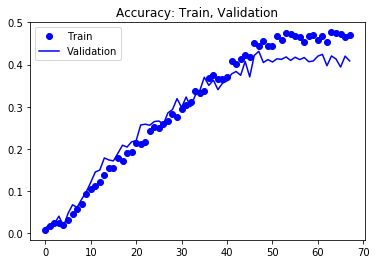

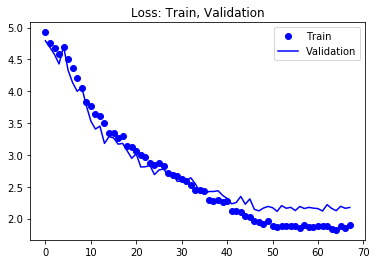

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [18]:
model.save('./models/model_{}_RAdam.h5'.format(MODELO))

# Predict

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 3025 images belonging to 120 classes.


In [21]:
probabilities = model.predict_generator(test_generator)

In [22]:
# Get Max Index
predicted_class_index=np.argmax(probabilities,axis=1)

# Dictionary: Index to Class
class_labels = list(test_generator.class_indices.keys())
index_to_labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Get List of Predictions
predictions = [index_to_labels[ix] for ix in predicted_class_index]

# Get Dictionary of Predictions
results=pd.DataFrame({"Filename":test_generator.filenames,
                      "Predictions":predictions})

In [23]:
results.head()

,Filename,Predictions
0,n02085620-Chihuahua\n02085620_10074.jpg,n02113023-Pembroke
1,n02085620-Chihuahua\n02085620_10131.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua\n02085620_10621.jpg,n02091032-Italian_greyhound
3,n02085620-Chihuahua\n02085620_1073.jpg,n02093428-American_Staffordshire_terrier
4,n02085620-Chihuahua\n02085620_10976.jpg,n02113023-Pembroke


In [24]:
results.to_csv("./models/results_details_{}.csv".format(MODELO), sep="|", index=False)

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class_index)

In [26]:
results_dict = {}
tp_sum, fp_sum = 0, 0

for ix, row in enumerate(cm):
    
    tp = row[ix]
    fp = np.sum(row) - tp   
    results_dict[ix] = [class_labels[ix],tp,fp,(tp/(tp+fp)*100)]

    tp_sum += tp
    fp_sum += fp
    
df_res = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Class","True Positive","False Positive","Accuracy"])

print("General Accuracy:{:0.2f}".format(tp_sum/(tp_sum+fp_sum)))

General Accuracy:0.40


In [27]:
df_res.head()

,Class,True Positive,False Positive,Accuracy
0,n02085620-Chihuahua,3,19,13.636364
1,n02085782-Japanese_spaniel,23,4,85.185185
2,n02085936-Maltese_dog,27,10,72.972973
3,n02086079-Pekinese,8,14,36.363636
4,n02086240-Shih-Tzu,5,27,15.625000


In [28]:
df_res.to_csv("./models/results_{}.csv".format(MODELO), sep="|", index=False)